In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [14]:
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
import scendict as sc
import netCDF4 as nc
import xarray as xr
import numpy as np
import warnings
import cartopy as cp
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import glob


In [33]:
## get surface area out
tmesh = nc.Dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
surfarea_m2 = tmesh['tmaskutil'][0,:,:] * tmesh['e1t'][0,:,:] * tmesh['e2t'][0,:,:]
#print(np.shape(surfarea_m2))
days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
surfar_times_days_in_month = np.zeros([12,149,182])

for i in range(0,12):
    surfar_times_days_in_month[i,:,:] = surfarea_m2 * days_in_month[i]

In [39]:
def get_yearly_Cflx(trun):
    yrstart = 1948; yrend = 2100
    yrs = np.arange(yrstart,yrend+1,1)
    yearflx_ts = np.zeros([len(yrs)])
    yearflx_ts_SO = np.zeros([len(yrs)])
    rdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_'
    print(trun)
    for i in range(0,len(yrs)):
        if i%50 == 0:
            print(i)
        yr = yrs[i]
        ncnam = 'diad'; varnam = 'Cflx'
        w = glob.glob(f'{rdir}{trun}/ORCA*{yr}01*{ncnam}_T.nc')

        try: 
            tnam = w[0]
            tfil = nc.Dataset(tnam)

            tq = tfil[varnam][:,:,:]
            sid = 60*60*24
        # now it's in petagrams total done by each cell 
            totflx = surfar_times_days_in_month * tq * sid * 12 * 1e-15
            yrflx= np.nansum(totflx)
            yearflx_ts[i] = yrflx
            yrflx_SO= np.nansum(totflx[0:39,:,:])
            yearflx_ts_SO[i] = yrflx_SO
        except:
            yearflx_ts[i] = np.nan
            
    return yearflx_ts, yearflx_ts_SO

In [48]:
yearflx_1AS1 = get_yearly_Cflx('1AS1')
yearflx_1AC1 = get_yearly_Cflx('1AC1')
yearflx_1AW1 = get_yearly_Cflx('1AW1')
yearflx_2AS1 = get_yearly_Cflx('2AS1')
yearflx_2AC1 = get_yearly_Cflx('2AC1')
yearflx_2AW1 = get_yearly_Cflx('2AS1')


1AS1
0
50
100
150
1AC1
0
50
100
150
1AW1
0
50
100
150
2AS1
0
50
100
150
2AC1
0
50
100
150
2AS1
0
50
100
150


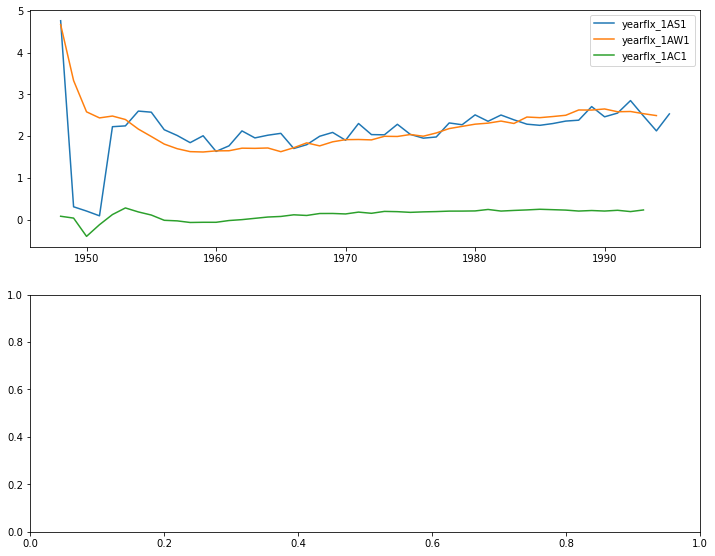

In [50]:
yrs = np.arange(1948,2101,1)
plotlab = ['yearflx_1AS1','yearflx_1AW1','yearflx_1AC1','yearflx_2AS1','yearflx_2AW1','yearflx_2AC1']
plot = [yearflx_1AS1,yearflx_1AW1,yearflx_1AC1,yearflx_2AS1,yearflx_2AW1,yearflx_2AC1]

fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(20*fact, 16*fact), \
                        facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,3):
    axs[0].plot(yrs,plot[i],label = plotlab[i])
    axs[0].legend()